In [1]:
from dask_jobqueue import PBSCluster
from dask.distributed import Client

In [2]:
# One node on Gadi has 48 cores - try and use up a full core before going to multiple nodes (jobs)

walltime = '01:00:00'
cores = 2
memory = '8GB'

cluster = PBSCluster(walltime=str(walltime), cores=cores, memory=str(memory),
                     job_extra=['-l ncpus='+str(cores),
                                '-l mem='+str(memory),
                                '-P xv83',
                                '-l storage=gdata/xv83+gdata/rt52+scratch/xv83'],
                     header_skip=["select"])

In [3]:
cluster.scale(jobs=1)
client = Client(cluster)

In [4]:
client

Client Scheduler: tcp://10.6.55.27:46849 Dashboard: http://10.6.55.27:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [5]:
# client.close()
# cluster.close()

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import functions as fn

### Try loading individual nc files and concat

In [125]:
f = xr.open_dataset('/g/data/xv83/dr6273/work/richardson_scratch/issues/xarray_write/2t_era5_moda_sfc_20190201-20190228.nc')
f.t2m.encoding

{'zlib': True,
 'shuffle': True,
 'complevel': 5,
 'fletcher32': False,
 'contiguous': False,
 'chunksizes': (1, 721, 1440),
 'source': '/g/data/xv83/dr6273/work/richardson_scratch/issues/xarray_write/2t_era5_moda_sfc_20190201-20190228.nc',
 'original_shape': (1, 721, 1440),
 'dtype': dtype('int16'),
 'missing_value': -32767,
 '_FillValue': -32767,
 'scale_factor': 0.0012360781018723392,
 'add_offset': 269.4665145293084}

In [126]:
m = xr.open_dataset('/g/data/xv83/dr6273/work/richardson_scratch/issues/xarray_write/2t_era5_moda_sfc_20190501-20190531.nc')
m.t2m.encoding

{'zlib': True,
 'shuffle': True,
 'complevel': 5,
 'fletcher32': False,
 'contiguous': False,
 'chunksizes': (1, 721, 1440),
 'source': '/g/data/xv83/dr6273/work/richardson_scratch/issues/xarray_write/2t_era5_moda_sfc_20190501-20190531.nc',
 'original_shape': (1, 721, 1440),
 'dtype': dtype('int16'),
 'missing_value': -32767,
 '_FillValue': -32767,
 'scale_factor': 0.0016177143099659714,
 'add_offset': 258.7720640676497}

In [193]:
ds = xr.concat([f, m], 'time', combine_attrs='drop')

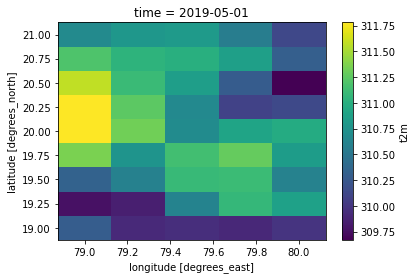

In [194]:
ds = ds.sel(latitude=slice(21,19), longitude=slice(79,80))
ds.t2m.sel(time='2019-05').plot()
ds.close()
ds.to_netcdf('./test.nc', mode='w')
ds.close()

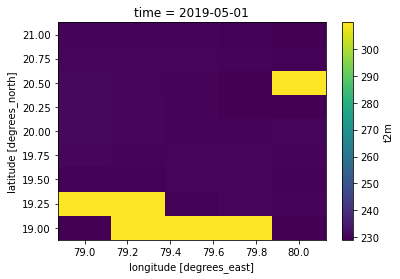

In [195]:
ds2 = xr.open_dataset('./test.nc')
ds2.t2m.sel(time='2019-05-01').plot()
ds2.close()

### With encoding

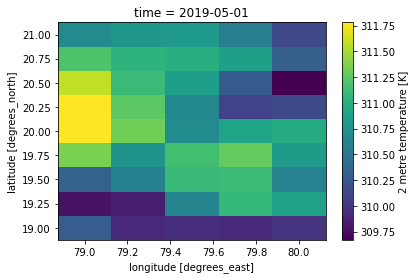

In [151]:
ds.to_netcdf('./test_encoding.nc', mode='w', encoding={'t2m': {'dtype': 'float32'}})
ds3 = xr.open_dataset('./test_encoding.nc')
ds3.t2m.sel(time='2019-05-01').plot()
ds3.close()

### Open encoded file, write without encoding and reopen

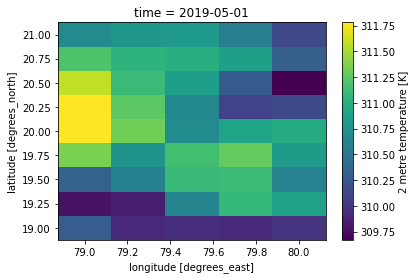

In [132]:
ds4 = xr.open_dataset('./test_encoding.nc')
ds4.to_netcdf('./test_encoding2.nc', mode='w')
ds4.close()
ds5 = xr.open_dataset('./test_encoding2.nc')
ds5.t2m.sel(time='2019-05-01').plot()
ds5.close()

In [120]:
f.encoding

{'zlib': True,
 'shuffle': True,
 'complevel': 5,
 'fletcher32': False,
 'contiguous': False,
 'chunksizes': (1, 721, 1440),
 'source': '/g/data/rt52/era5/single-levels/monthly-averaged/2t/2019/2t_era5_moda_sfc_20190201-20190228.nc',
 'original_shape': (1, 721, 1440),
 'dtype': dtype('int16'),
 'missing_value': -32767,
 '_FillValue': -32767,
 'scale_factor': 0.0012360781018723392,
 'add_offset': 269.4665145293084}

In [121]:
m.encoding

{'zlib': True,
 'shuffle': True,
 'complevel': 5,
 'fletcher32': False,
 'contiguous': False,
 'chunksizes': (1, 721, 1440),
 'source': '/g/data/rt52/era5/single-levels/monthly-averaged/2t/2019/2t_era5_moda_sfc_20190501-20190531.nc',
 'original_shape': (1, 721, 1440),
 'dtype': dtype('int16'),
 'missing_value': -32767,
 '_FillValue': -32767,
 'scale_factor': 0.0016177143099659714,
 'add_offset': 258.7720640676497}

# What does the encoding look like?

In [74]:
root_path = '/g/data/rt52/era5/single-levels/monthly-averaged/'
import os
files = sorted(os.listdir(root_path+'2t/2019/'))
files

['2t_era5_moda_sfc_20190101-20190131.nc',
 '2t_era5_moda_sfc_20190201-20190228.nc',
 '2t_era5_moda_sfc_20190301-20190331.nc',
 '2t_era5_moda_sfc_20190401-20190430.nc',
 '2t_era5_moda_sfc_20190501-20190531.nc',
 '2t_era5_moda_sfc_20190601-20190630.nc',
 '2t_era5_moda_sfc_20190701-20190731.nc',
 '2t_era5_moda_sfc_20190801-20190831.nc',
 '2t_era5_moda_sfc_20190901-20190930.nc',
 '2t_era5_moda_sfc_20191001-20191031.nc',
 '2t_era5_moda_sfc_20191101-20191130.nc',
 '2t_era5_moda_sfc_20191201-20191231.nc']

In [75]:
files_to_open = [root_path+'2t'+'/'+str(2019)+'/'+files[i] for i in range(12)]

In [76]:
offsets = []
for f in [files_to_open[i] for i in range(12)]:
    offsets.append(xr.open_dataset(f).t2m.encoding['add_offset'])

In [77]:
offsets

[268.3445736472345,
 269.4665145293084,
 262.14209189787596,
 258.78985195821474,
 258.7720640676497,
 259.18679874346765,
 262.91154676032846,
 260.22661482526166,
 258.81987439954327,
 263.0714212346324,
 268.90530549252924,
 268.77923463395865]